In [1]:
# 1. import module

import pandas as pd
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from pycaret.regression import *

from sklearn.model_selection import train_test_split 
from sklearn import metrics
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 

import copy


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.max_seq_items = None


In [2]:
# 2. data import

raw_data = pd.read_csv("./Data_2021_10_14_v1 (N98923)/Data.csv")


# 학습할 파라미터를 제외한 나머지 아웃풋 삭제
output = ["Lmt","Lmr","Llt","Llr","k","Lt","Lr","Lm","Rt","Rr","I1","I2","Zt","Zr","Zm","copperloss_tx","copperloss_rx"]
parameter = "Llt"
output.remove(parameter)

for pam in output :
    raw_data = raw_data.drop(columns=pam)

# NaN 데이터 삭제
raw_data = raw_data.dropna()

display(raw_data.head())

,N1,N2,d1,d2,freq,move_tx,move_rx,offset_tx,offset_rx,per,space1,space2,space3,space4,l1,l2,h1,w1,Llt
0,8,8,6.0,9.7,49000.0,2,5,7,-9,1480,1,23,3,55,19,41,166,24,6.704324
1,8,8,11.7,10.7,49000.0,6,4,18,-5,1160,5,47,3,31,31,72,251,248,13.703235
2,8,8,9.0,5.4,49000.0,4,1,9,-18,4192,5,31,7,28,33,40,191,212,19.559244
3,8,8,9.5,4.2,49000.0,6,3,14,-7,3419,1,21,6,38,15,30,185,221,16.173505
4,11,11,7.5,10.3,58000.0,1,2,13,-17,4445,7,50,6,46,16,69,207,241,35.181363


In [3]:
# 7. define outlier search function
def get_outlier(df=None, column=None, weight=1.5):
    
    # column 데이터만 추출, 1/4 분위와 3/4 분위 지점을 np.percentile로 구함. 
    data = df[column]
    quantile_25 = np.percentile(data.values, 25)  # 1/4 분위
    quantile_75 = np.percentile(data.values, 75)  # 3/4 분위
    
    # IQR을 구하고, IQR에 1.5를 곱하여 최대값과 최소값 지점 구함. 
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight  # 이상치 최소 기준
    highest_val = quantile_75 + iqr_weight # 이상치 최대 기준
    
    # 최대값 보다 크거나, 최소값 보다 작은 값을 아웃라이어로 설정하고 DataFrame index 반환. 
    outlier_index = data[(data < lowest_val) | (data > highest_val)].index
    
    return outlier_index


# 8. data pre-processing

# target 변수 제외
col_input = list(raw_data.columns)[:-1]
print(col_input)

# outlier 탐색 및 제거
outlier_index = {}
for i, colName in enumerate(col_input):
     outlier_index[i] = get_outlier(df=raw_data, column=f'{colName}', weight=1.5)
outlier_index

# 각각의 숫자들 리스트 안에 넣기
outlier_list = []
for i in range(len(outlier_index)):
    if list(outlier_index[i].values) == []:
        continue
    outlier_list.append(list(outlier_index[i].values))

# 리스트 안의 리스트들을 하나로 합치기
outlier_list = sum(outlier_list , [])
print('개수:', len(outlier_list))

# 중복 숫자 제거
outlier_list = set(outlier_list)
print('개수:', len(outlier_list))

# 다시 리스트 타입으로 변환
outlier_list = list(outlier_list)
print(type(outlier_list))

# 리스트 숫자 정렬
outlier_list.sort()

# outlier를 갖는 index에 해당하는 data drop
for i in outlier_list:
    raw_data.drop(i, axis=0, inplace=True)
raw_data.shape

['N1', 'N2', 'd1', 'd2', 'freq', 'move_tx', 'move_rx', 'offset_tx', 'offset_rx', 'per', 'space1', 'space2', 'space3', 'space4', 'l1', 'l2', 'h1', 'w1']
개수: 2200
개수: 2197
<class 'list'>


(96723, 19)

In [4]:
data = copy.deepcopy(raw_data)

col_input

for col_name in list(col_input) : 
    exec(f'{col_name} = data["{col_name}"]')


N1s = N1**2
N2s = N2**2
offset = abs(offset_tx-offset_rx)
length1 = N1 * (l1*2 + space1*2 + w1 + space3*2)/2 + N1 * (l1*2 + space1*2 + w1 + space3*2)/2
length4 = N2 * (l1*2 + space2*2 + w1 + space4*2)/2 + N2 * (l2*2 + space2*2 + w1 + space4*2)/2
window1 = (l1 * 2 + space1 *2) * (w1 + space3 *2)
window2 = (l1 * 2 + space2 *2) * (w1 + space4 *2)
window_ratio = window2/window1
from_l2 = (l2) - (space2)
hw1 = N1*d1 + (N1-1)*move_tx
hw2 = N2*d2 + (N2-1)*move_rx
space12 = space2-d2/2-space1
space34 = space4-d2/2-space3

ex_name = ["offset","length1","length4","window2","window_ratio","from_l2","hw1","hw2","space12","space34"]

for col_name in ex_name :
    exec(f'data["{col_name}"] = {col_name}')


data.head()

,N1,N2,d1,d2,freq,move_tx,move_rx,offset_tx,offset_rx,per,space1,space2,space3,space4,l1,l2,h1,w1,Llt,offset,length1,length4,window2,window_ratio,from_l2,hw1,hw2,space12,space34
0,8,8,6.0,9.7,49000.0,2,5,7,-9,1480,1,23,3,55,19,41,166,24,6.704324,16,560.0,1920.0,11256,9.380000,18,62.0,112.6,17.15,47.15
1,8,8,11.7,10.7,49000.0,6,4,18,-5,1160,5,47,3,31,31,72,251,248,13.703235,23,2608.0,4056.0,48360,2.644357,25,135.6,113.6,36.65,22.65
2,8,8,9.0,5.4,49000.0,4,1,9,-18,4192,5,31,7,28,33,40,191,212,19.559244,27,2416.0,3224.0,34304,1.997205,9,100.0,50.2,23.30,18.30
4,11,11,7.5,10.3,58000.0,1,2,13,-17,4445,7,50,6,46,16,69,207,241,35.181363,30,3289.0,5698.0,43956,3.776938,19,92.5,133.3,37.85,34.85
5,11,11,7.1,10.1,58000.0,1,2,8,-15,3970,6,44,6,48,24,66,184,75,18.637053,23,1617.0,3839.0,23256,4.455172,22,88.1,131.1,32.95,36.95


In [5]:
# 12. split input/output

X = data.drop(columns=parameter)
Y = data[parameter]


X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state = 765)


# minmax normalize
scaler = MinMaxScaler()
for colName in col_input+ex_name:
    X_train[colName] = scaler.fit_transform(X_train[colName].values.reshape(-1, 1))
    X_test[colName] = scaler.fit_transform(X_test[colName].values.reshape(-1, 1))

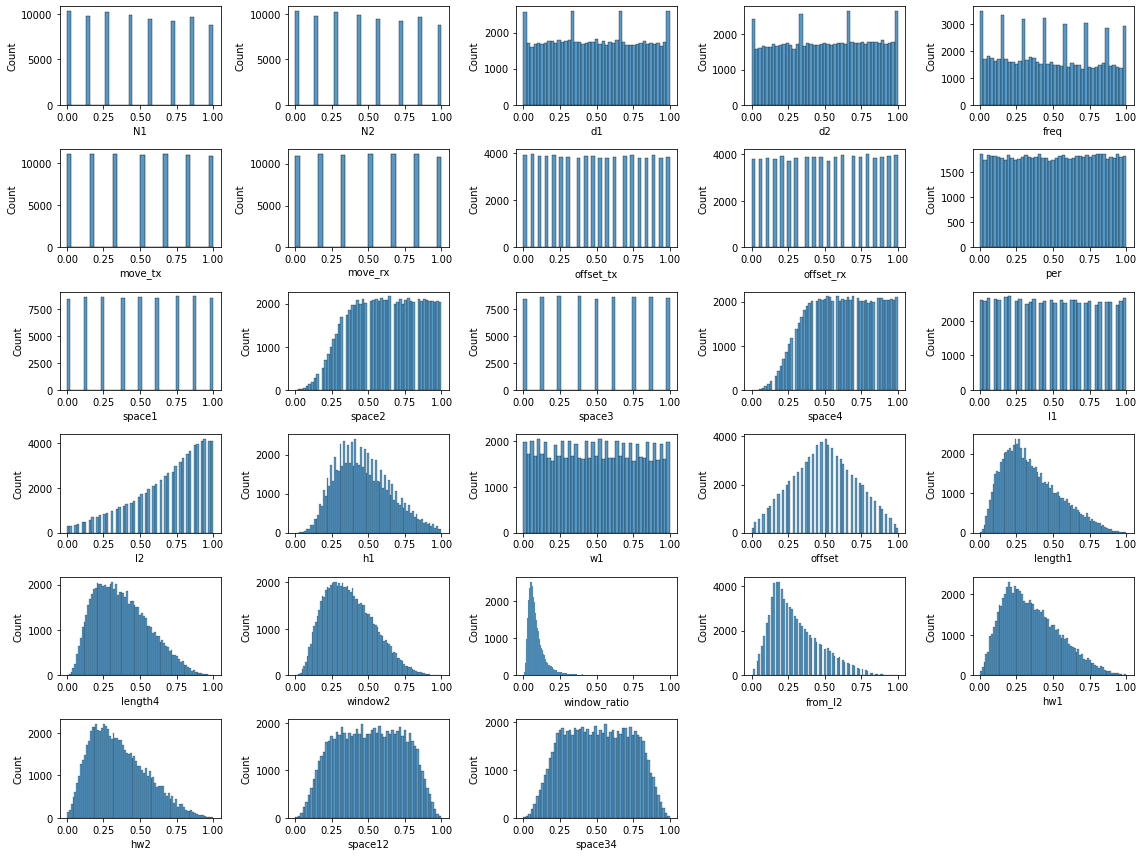

In [7]:
# 13. check data distribution (after normalize)
plt.figure(figsize=(16, 12))
for i, colName in enumerate(list(X_train.columns)) :
    plt.subplot(6, 5, i+1)
    sns.histplot(X_train.loc[:, colName])
plt.tight_layout()
plt.show()

<AxesSubplot:>

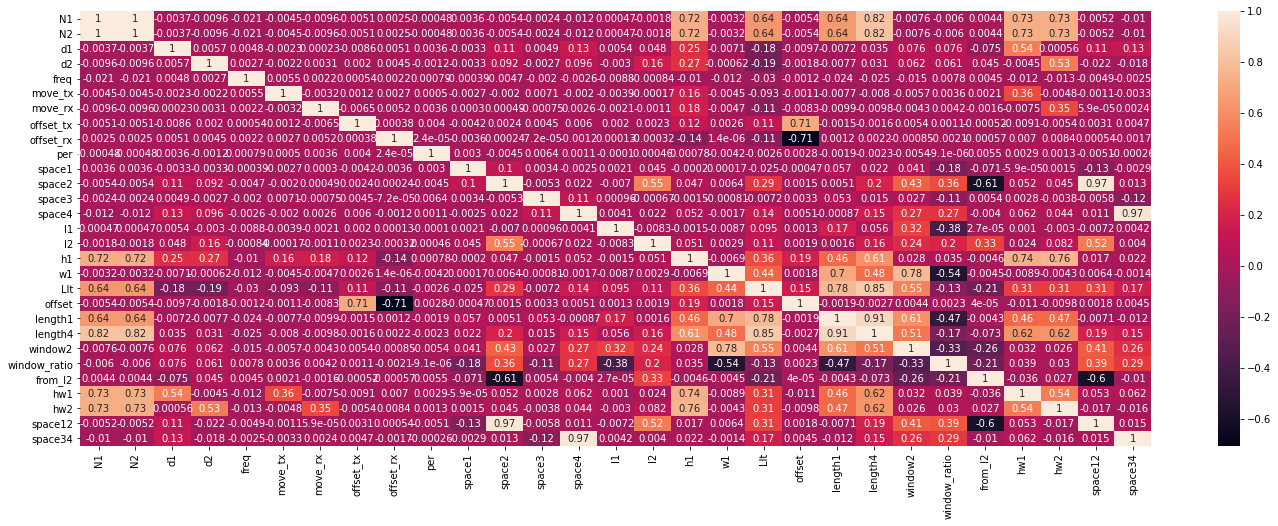

In [8]:
# 11. show corelation between each parameter (after pre-processing)

plt.figure(figsize=(24, 8))
sns.heatmap(data=data.corr(), annot=True)

In [9]:
model = LGBMRegressor(random_state=765)
model.fit(X_train,Y_train)

print(model)

LGBMRegressor(random_state=765)


[0.9913584079286734, 0.48315965533581023, 0.5314631168516364, 0.7290151691505715, 4.137059631299935, -0.6834782991628264]
[0.9902885061693517, 0.49309576493183943, 0.590823420783415, 0.7686503891779507, 4.148650418412106, -0.5090479580320016]
[0.9907418570896287, 0.48495851790954886, 0.5582332340439208, 0.7471500746462659, 4.1658653066343785, -0.5950295511058613]
[0.9905306255220678, 0.5019578787173516, 0.5666660103692659, 0.7527722167888942, 4.283807039861856, -0.6230914747483965]
[0.9907515991265888, 0.4917668586399824, 0.5698798427104972, 0.7549038632239851, 4.201355788595369, -0.5129438147846722]


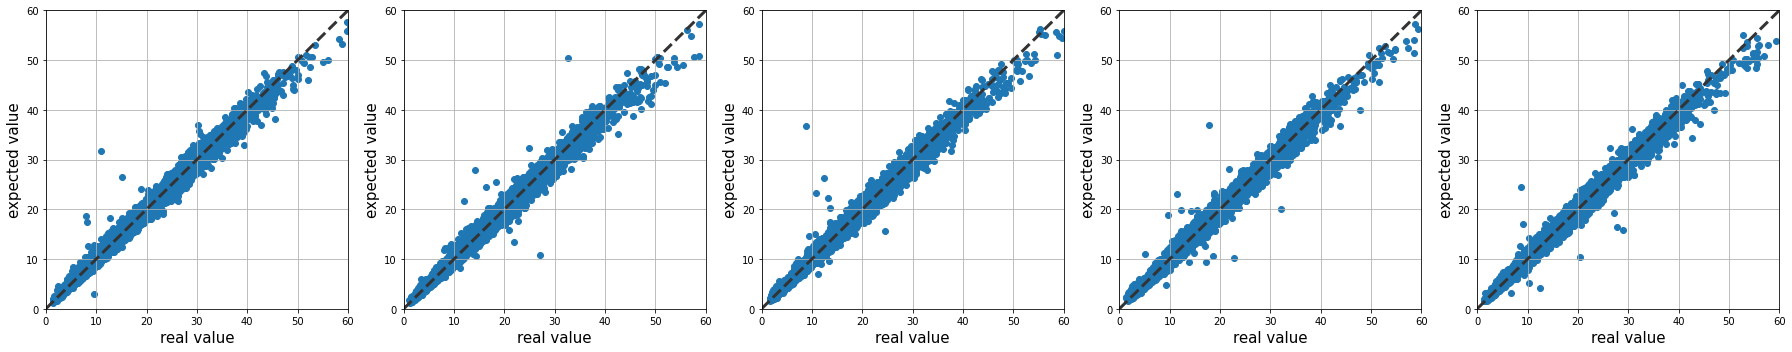

In [10]:
# 교차 검증용 데이터셋 구성
df_trains = []
df_valids = []

# MAPE 정의
def def_MAPE(y_test, y_pred):
	return np.mean(np.abs((y_test - y_pred) / y_test)) * 100 

# MPE 정의
def def_MPE(y_test, y_pred): 
	return np.mean((y_test - y_pred) / y_test) * 100

# KFold 검증
i = 0
plt.figure(figsize=(25, 5))
kfold = KFold(n_splits=5, random_state=765, shuffle=True)
for train_idx, test_idx in kfold.split(X[col_input]):

    # fold 후 train, test set 분할
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    Y_train, Y_test = Y.iloc[train_idx], Y.iloc[test_idx]

    # regression model 생성
    model.fit(X_train, Y_train)

    # 예측
    fold_pred = model.predict(X_test)

    # 성능계산
    R2 = r2_score(Y_test, fold_pred)
    MAE = mean_absolute_error(Y_test, fold_pred)
    MSE = mean_squared_error(Y_test, fold_pred)
    RMSE = np.sqrt(MSE)
    MAPE = def_MAPE(Y_test, fold_pred)
    MPE = def_MPE(Y_test, fold_pred)

    print([R2, MAE,MSE,RMSE,MAPE,MPE])

    plt.subplot(1, 5, i+1)
    plt.scatter(Y_test, fold_pred)
    plt.xlabel("real value", fontsize=15)
    plt.ylabel("expected value", fontsize=15)
    plt.grid(True)
    plt.xlim(0, 60)
    plt.ylim(0, 60)
    plt.plot([0, 60], [0, 60], ls="--", c=".2", linewidth=3.0)
    i = i+1

plt.tight_layout()
plt.show()

In [11]:
from sklearn.model_selection import GridSearchCV

parameters = {
    "n_estimators" : [1000,3000,10000],
    'n_jobs' : [-1],
    'learning_rate': [0.05],
    'max_depth' : [-1,2,3,4,5,10,20,30,50],
    'num_leaves' : [31,60,80,100,127],
    }

#cv=5 5번의 교차검증.
grid = GridSearchCV(LGBMRegressor(random_state=0), verbose=2, param_grid = parameters, cv=kfold)
grid.fit(X_train, Y_train)

Fitting 5 folds for each of 135 candidates, totalling 675 fits
[CV] learning_rate=0.05, max_depth=-1, n_estimators=1000, n_jobs=-1, num_leaves=31 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.05, max_depth=-1, n_estimators=1000, n_jobs=-1, num_leaves=31, total=   1.8s
[CV] learning_rate=0.05, max_depth=-1, n_estimators=1000, n_jobs=-1, num_leaves=31 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


[CV]  learning_rate=0.05, max_depth=-1, n_estimators=1000, n_jobs=-1, num_leaves=31, total=   1.7s
[CV] learning_rate=0.05, max_depth=-1, n_estimators=1000, n_jobs=-1, num_leaves=31 
[CV]  learning_rate=0.05, max_depth=-1, n_estimators=1000, n_jobs=-1, num_leaves=31, total=   1.6s
[CV] learning_rate=0.05, max_depth=-1, n_estimators=1000, n_jobs=-1, num_leaves=31 
[CV]  learning_rate=0.05, max_depth=-1, n_estimators=1000, n_jobs=-1, num_leaves=31, total=   1.6s
[CV] learning_rate=0.05, max_depth=-1, n_estimators=1000, n_jobs=-1, num_leaves=31 
[CV]  learning_rate=0.05, max_depth=-1, n_estimators=1000, n_jobs=-1, num_leaves=31, total=   1.6s
[CV] learning_rate=0.05, max_depth=-1, n_estimators=1000, n_jobs=-1, num_leaves=60 
[CV]  learning_rate=0.05, max_depth=-1, n_estimators=1000, n_jobs=-1, num_leaves=60, total=   2.3s
[CV] learning_rate=0.05, max_depth=-1, n_estimators=1000, n_jobs=-1, num_leaves=60 
[CV]  learning_rate=0.05, max_depth=-1, n_estimators=1000, n_jobs=-1, num_leaves=60, 

[Parallel(n_jobs=1)]: Done 675 out of 675 | elapsed: 83.2min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=765, shuffle=True),
             estimator=LGBMRegressor(random_state=0),
             param_grid={'learning_rate': [0.05],
                         'max_depth': [-1, 2, 3, 4, 5, 10, 20, 30, 50],
                         'n_estimators': [1000, 3000, 10000], 'n_jobs': [-1],
                         'num_leaves': [31, 60, 80, 100, 127]},
             verbose=2)

In [12]:
grid.best_params_

{'learning_rate': 0.05,
 'max_depth': 4,
 'n_estimators': 10000,
 'n_jobs': -1,
 'num_leaves': 31}

In [13]:
#model = LGBMRegressor(random_state=765, learning_rate=0.05, max_depth=10, n_estimators=5000)
model = LGBMRegressor(random_state=765, **grid.best_params_)
model.fit(X_train,Y_train)

print(model)

LGBMRegressor(learning_rate=0.05, max_depth=4, n_estimators=10000,
              random_state=765)


[0.9976072457410745, 0.2149370279716191, 0.14715582797850738, 0.3836089519009005, 1.8635940938304538, -0.09167345498956367]
[0.9974013422248759, 0.21764048710977738, 0.15809595340511826, 0.39761281846177726, 1.8562964697933024, -0.07129778590025894]
[0.997258286281601, 0.21275362919794602, 0.1653156287023733, 0.4065902466886943, 1.8385760204365622, -0.10587850906434626]
[0.9974095487564318, 0.22200025795655326, 0.1550177020319354, 0.3937228746617796, 1.8679391124837952, -0.07739746411243376]
[0.9976945490030426, 0.2171026771510537, 0.14206024041411416, 0.3769087958831873, 1.8655866056376549, -0.07022018082735475]


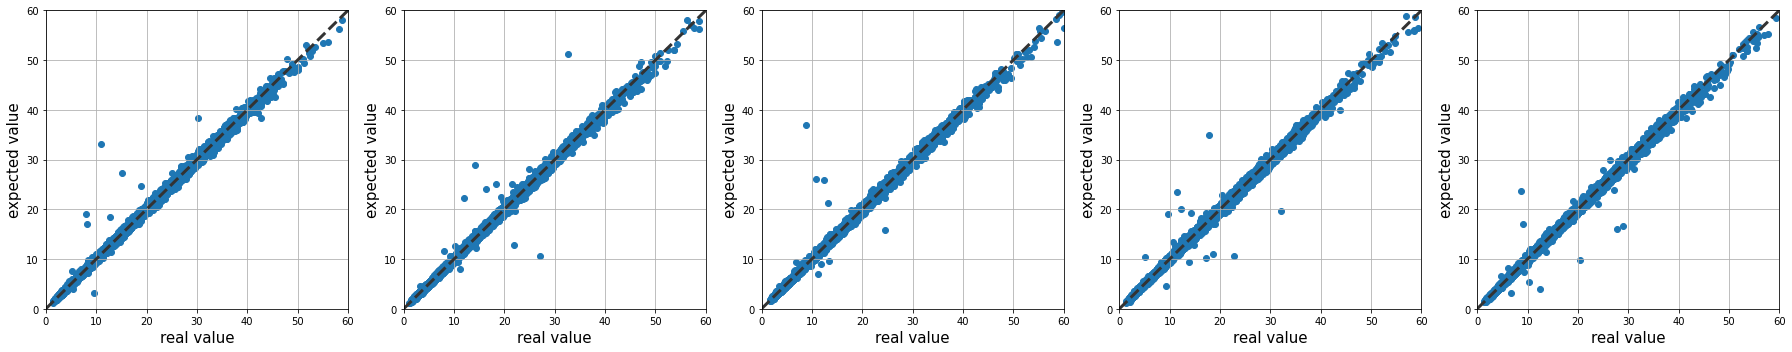

In [14]:
# 교차 검증용 데이터셋 구성
df_trains = []
df_valids = []

# MAPE 정의
def def_MAPE(y_test, y_pred):
	return np.mean(np.abs((y_test - y_pred) / y_test)) * 100 

# MPE 정의
def def_MPE(y_test, y_pred): 
	return np.mean((y_test - y_pred) / y_test) * 100

# KFold 검증
i = 0
plt.figure(figsize=(25, 5))
kfold = KFold(n_splits=5, random_state=765, shuffle=True)
for train_idx, test_idx in kfold.split(X[col_input]):

    # fold 후 train, test set 분할
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    Y_train, Y_test = Y.iloc[train_idx], Y.iloc[test_idx]

    # regression model 생성
    model.fit(X_train, Y_train)

    # 예측
    fold_pred = model.predict(X_test)

    # 성능계산
    R2 = r2_score(Y_test, fold_pred)
    MAE = mean_absolute_error(Y_test, fold_pred)
    MSE = mean_squared_error(Y_test, fold_pred)
    RMSE = np.sqrt(MSE)
    MAPE = def_MAPE(Y_test, fold_pred)
    MPE = def_MPE(Y_test, fold_pred)

    print([R2, MAE,MSE,RMSE,MAPE,MPE])

    plt.subplot(1, 5, i+1)
    plt.scatter(Y_test, fold_pred)
    plt.xlabel("real value", fontsize=15)
    plt.ylabel("expected value", fontsize=15)
    plt.grid(True)
    plt.xlim(0, 60)
    plt.ylim(0, 60)
    plt.plot([0, 60], [0, 60], ls="--", c=".2", linewidth=3.0)
    i = i+1

plt.tight_layout()
plt.show()

In [18]:
from sklearn.ensemble import GradientBoostingRegressor

est = GradientBoostingRegressor(
    n_estimators=100, learning_rate=0.1, max_depth=1, random_state=0
    ).fit(X_train, Y_train)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

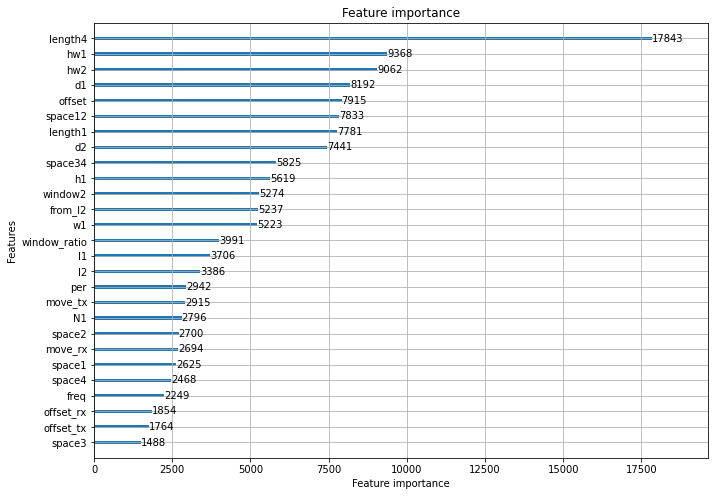

In [20]:
from lightgbm import plot_importance

fig, ax = plt.subplots(figsize=(11,8))
plot_importance(model, ax)